In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

C:\Users\jjong\AppData\Local\Temp\ipykernel_13208\1568586482.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 전처리 설정

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

## 데이터 로드 및 확인

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./',
                                        train=True,
                                        download=True,
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='./',
                                       train=False,
                                       download=True,
                                       transform=transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 14007092.92it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [6]:
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [7]:
classes = ('plane', 'car', 'bird','cat','deer','dog','frog','horse','ship','truck')

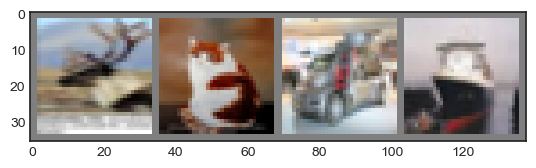

	deer 	cat 	car 	ship


In [11]:
def imshow(img):
    img = img/2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

## 신경망 구성

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

## Loss Function & Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

## Model Training

In [19]:
for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.2126323110461237
Epoch: 1, Batch: 4000, Loss: 1.9032183986008167
Epoch: 1, Batch: 6000, Loss: 1.7214328806698322
Epoch: 1, Batch: 8000, Loss: 1.603102599710226
Epoch: 1, Batch: 10000, Loss: 1.5116849800050258
Epoch: 1, Batch: 12000, Loss: 1.5102507106810807
Epoch: 2, Batch: 2000, Loss: 1.4048456632718445
Epoch: 2, Batch: 4000, Loss: 1.3889402952380479
Epoch: 2, Batch: 6000, Loss: 1.3619102285318077
Epoch: 2, Batch: 8000, Loss: 1.3342648089006544
Epoch: 2, Batch: 10000, Loss: 1.3143005035743118
Epoch: 2, Batch: 12000, Loss: 1.3176148549839855
Epoch: 3, Batch: 2000, Loss: 1.2296166688967496
Epoch: 3, Batch: 4000, Loss: 1.2413886683955788
Epoch: 3, Batch: 6000, Loss: 1.207927356503904
Epoch: 3, Batch: 8000, Loss: 1.2108106212280692
Epoch: 3, Batch: 10000, Loss: 1.2007168639246375
Epoch: 3, Batch: 12000, Loss: 1.1662964115059002
Epoch: 4, Batch: 2000, Loss: 1.1003553763125091
Epoch: 4, Batch: 4000, Loss: 1.1148912817332894
Epoch: 4, Batch: 6000, Loss: 1.12982

## Model Save & Load

In [20]:
path ='./CIFAR_net.pth'
torch.save(net.state_dict(), path)

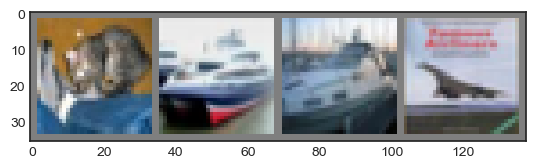

	cat 	ship 	ship 	plane


In [22]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

In [23]:
net = Net().to(device)
net.load_state_dict(torch.load(path))

<All keys matched successfully>

## Model Test

In [24]:
outputs = net(images.to(device))

In [26]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	cat 	ship 	ship 	ship


In [27]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct/total)

61.57


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane: 63.5%
Accuracy of car: 78.0%
Accuracy of bird: 47.7%
Accuracy of cat: 56.3%
Accuracy of deer: 52.9%
Accuracy of dog: 42.3%
Accuracy of frog: 61.8%
Accuracy of horse: 67.4%
Accuracy of ship: 86.4%
Accuracy of truck: 59.4%
